In [91]:
!pwd

/Users/nico/panoseti/panoseti-software/cloud-detection/model_training


In [58]:
import os
import sys
from time import sleep
import math
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)

import torch
from torchvision.transforms import v2
from sklearn.metrics import PrecisionRecallDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = 'grey'
plt.rcParams["font.size"] = 14

import seaborn as sns
from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
import tqdm.notebook as tqdm
import gc

sys.path.append('../dataset_construction')
sys.path.append('../../util')
from pano_utils import *
from panoseti_file_interfaces import ObservingRunInterface

%load_ext autoreload


from cnn_model import *
from data_loaders import *
from training_utils import *
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Frame browsing utils
# cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
# clear = labeled[labeled['label'] == 'clear_night_sky']
img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

def make_img_grid(label, cols=8, rows_per_plot=6):
    """Grid of all classified images labeled as the given label"""
    with_label = labeled.loc[labeled['label'] == label]
    imgs = []

    for fuid in with_label['feature_uid']:
        data = np.load(get_path(fuid, img_type), allow_pickle=False)
        imgs.append(data)
    if len(imgs) == 0:
        print(f'No images labeled as "{label}"')
        return
    else:
        print(f'Images you classified as "{label}":')
    # Limit num rows in plot to ensure consistently-sized figures
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                feature_uid = with_label['feature_uid'].iloc[img_idx]
                ax.set_title(f'{23}{feature_uid[:6]}')  # Label each plot with first 6 chars of feature_uid
                ax.imshow(img, vmin=-150, vmax=150, cmap='icefire')
        plt.show()
        plt.close()

def add_module_id_and_time(df):
    df_with_pano_uid = pd.merge(
        left = df,
        right = inference_data.inference_session.feature_df,
        on = 'feature_uid'
    )
    df_with_module_id_and_time = pd.merge(
        left = df_with_pano_uid,
        right = inference_data.inference_session.pano_df,
        on = 'pano_uid'
    ).loc[:,['feature_uid', 'module_id', 'label', 'frame_unix_t']]
    df_with_module_id_and_time['date'] = pd.to_datetime(df_with_module_id_and_time['frame_unix_t'], unit='s')
    return df_with_module_id_and_time

def get_with_label(label, module_id):
    if label == 'cloudy':
        with_label = cloudy
    elif label == 'clear':
        with_label = clear
    else:
        raise ValueError('label must be either "cloudy" or "clear"')
    if module_id != 'All':
        assert 'module_id' in with_label, "'module_id' must be added to the data frame."
        assert module_id in with_label['module_id'].unique(), f"Found no data with module_id = {module_id}."
        with_label = with_label[with_label['module_id'] == module_id]
    return with_label


def do_movie(label, step, start_frame=1, frame_time=0.01, module_id=None):
    try:
        # for i, fuid in enumerate(with_label['feature_uid'][::step]):
        with_label = get_with_label(label, module_id)

        for i in range(max(min(start_frame, len(with_label)), 1), len(with_label) + 1, step):
            plot_frame(module_id, label, step, i)
            display.clear_output(wait=True)
            # plt.show()
            sleep(frame_time)
            # plt.close()
        print('Done')
    except KeyboardInterrupt:
        print('Exiting...')
        return
    finally:
        plt.close()
        gc.collect()


def browse_labels(continuous_update=True):
    try:
        initial_label = 'cloudy'
        label_options = ['cloudy', 'clear']
        if len(cloudy) == 0 and len(clear) == 0:
            raise ValueError('No images!')
        elif len(cloudy) == 0:
            initial_label = 'clear'
            label_options.remove('cloudy')
        initial_df = get_with_label(initial_label, module_id='All')

        module_id_options = ['All']
        module_id_options.extend(list(labeled['module_id'].unique()))
        # print(module_id_options)
        
        i_widget = widgets.IntSlider(
            min=1,
            max=len(initial_df),
            step=1,
            value=1, 
            description='seqno',
            continuous_update=continuous_update,
            layout=Layout(width='85%'),
            auto_advance=True)
        label_widget = widgets.Dropdown(
            options=label_options,
            value = initial_label,
            description='label',
            layout=Layout(width='50%', justify_content='center')
        )
        module_id_widget = widgets.Dropdown(
            options=module_id_options,
            value = 'All',
            description='module_id',
            layout=Layout(width='50%', justify_content='center')
        )

        def update_i_widget(*args):
            label = label_widget.value
            module_id = module_id_widget.value
            with_label = get_with_label(label, module_id)
            i_widget.max = len(with_label)
            i_widget.value = min(i_widget.value, len(with_label))
                
        label_widget.observe(update_i_widget, 'value')
        module_id_widget.observe(update_i_widget, 'value')
        interact(
            plot_frame,
            label = label_widget,
            step = fixed(1),
            i = i_widget,
            module_id = module_id_widget
        )
    except KeyboardInterrupt:
        print('Exiting...')
        return
    finally:
        plt.close()
        gc.collect()


def plot_frame(module_id, label, step, i):
    with_label = get_with_label(label, module_id)
    fuid, actual_module_id, date = with_label[['feature_uid', 'module_id', 'date']].iloc[i - 1]
    data = np.load(get_path(fuid, img_type))    
    fig, axs = plt.subplots(1, 3, figsize=(10.5, 4.8), constrained_layout=True)
    # fig.suptitle(f'[{label}] feature_uid: {fuid[:9]:>10}; ({(i-1)//step + 1} / {len(with_label) // step})')
    fig.suptitle(f'[inference: "{label}"] '
                 f'[module: {actual_module_id}] '
                 f'[fuid: {fuid[:9]}] '
                 f'[seqno: {i} / {len(with_label)}]\n'
                 f'[UTC: {date}]')

    # FFT of original stacked original
    fft_idx = 0
    shape = (64, 64)
    data = np.load(get_path(fuid, 'raw-derivative-fft.-60'))
    im_fft = axs[fft_idx].imshow(
        data, vmin=3.5, vmax=12, cmap='mako'
    )
    cbar_fft = fig.colorbar(im_fft, label='$\log|X[k, \ell]|$', fraction=0.046, location='bottom')
    axs[fft_idx].axis('off')
    axs[fft_idx].set_title('FFT of Derivative')

    # Original stacked pano image
    orig_idx = 2
    im_orig = axs[orig_idx].imshow(
        np.load(get_path(fuid, 'raw-original')), vmin=-125*50, vmax=125*50, cmap='icefire'#cmap='crest_r'
    )
    cbar_orig = fig.colorbar(im_orig, label='Counts', fraction=0.046, location='bottom')
    axs[orig_idx].axis('off')
    axs[orig_idx].set_title('Original [6ms integr.]')

    # -60 second time derivative
    deriv_idx = 1
    im_deriv = axs[deriv_idx].imshow(
        np.load(get_path(fuid, 'raw-derivative.-60')), vmin=-125*50, vmax=125*50, cmap='icefire'
    )
    cbar_deriv = fig.colorbar(im_deriv, label = r'$\Delta$ Counts', fraction=0.046, location='bottom')
    axs[deriv_idx].axis('off')
    axs[deriv_idx].set_title('Derivative: Orig(0s) – Orig(-60s)')
    plt.show()
    plt.close()

In [77]:
batch_size = 64
batch_id = 1006   # Cloudy data, not in training set
# batch_id = 9   # Clear data, not in training set


# Creating the datasets
mean = [7.4, 0, 0]
std = [5.5, 60, 75]

transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=mean, std=std),
    v2.ToDtype(torch.float),
])

inference_data = CloudDetectionInference(
    batch_id = batch_id,
    transform = transform
)
get_path = inference_data.inference_session.get_pano_feature_fpath
inference_loader = torch.utils.data.DataLoader(
  dataset=inference_data,
  batch_size=batch_size
)

In [89]:
model = CloudDetection()
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth', weights_only=True))

device = get_device()
model.to(device);

THRESHOLD = 0

predictions = np.array([], dtype=int)
with torch.no_grad():
    model.eval() # Put model in eval mode
    for img_data in tqdm.tqdm(inference_loader, unit="batch"):
        x = img_data
        x = x.to(device=device, dtype=torch.float)
        pred = model(x).to('cpu').numpy()
        # class_preds = np.argmax(pred, axis=1)
        class_preds = np.diff(pred, axis=1)[:, 0] >= THRESHOLD
        predictions = np.concatenate((predictions, class_preds))

inference_data.inference_session.add_labels(predictions)
inference_data.inference_session.write_labels(save_to_training_data=False)
del model
print(predictions)

  0%|          | 0/31 [00:00<?, ?batch/s]

../dataset_construction/inference_batch_labels/task_cloud-detection.type_inference.batch-id_1006.user-uid_INFERENCE
[1 1 1 ... 1 1 1]


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

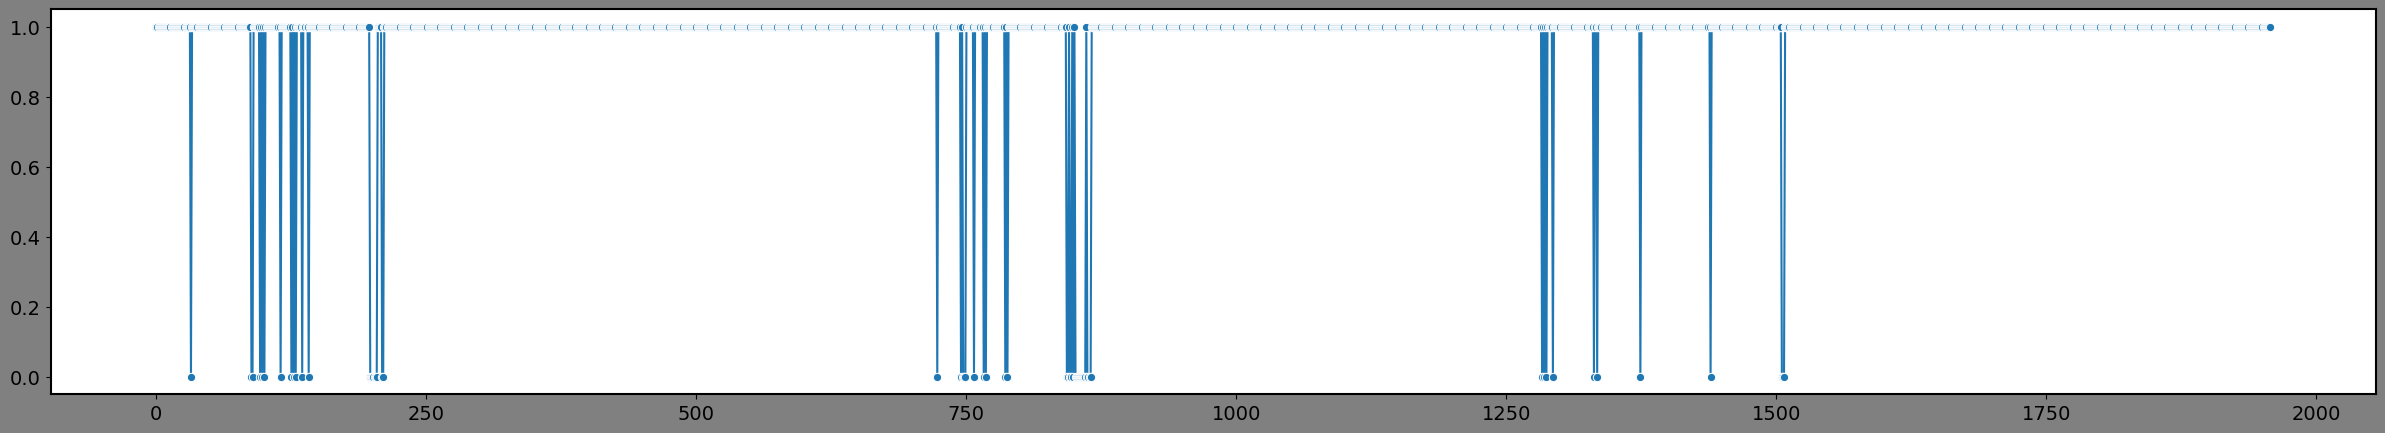

In [90]:
plt.figure(figsize=(30, 5))
sns.lineplot(predictions, marker="o")

In [87]:
gc.collect()
labeled = add_module_id_and_time(inference_data.inference_session.labeled_df)

cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
clear = labeled[labeled['label'] == 'clear_night_sky']
print(f'ncloudy = {len(cloudy)}, nclear = {len(clear)}')

ncloudy = 1897, nclear = 61


In [83]:
browse_labels(continuous_update=True)

interactive(children=(Dropdown(description='module_id', layout=Layout(justify_content='center', width='50%'), …

In [92]:
# View all cloudy images
# label can be set to either 'cloudy' or 'clear'
gc.collect()
do_movie(label = 'clear', step=1, start_frame=0, module_id=3, frame_time=0)

Done


In [ ]:
make_img_grid('not_clear_cloudy')
make_img_grid('clear_night_sky')